# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
! pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 6.5 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [5]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
print(tf.__version__)

2.8.0


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [8]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [9]:
# Specify data URI
URI = os.path.join(os.getcwd(), 'data/ENB2012_data.xlsx')

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [10]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

2022-06-16 07:57:56.426648: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 07:57:56.853407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38184 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [11]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Train the Model

In [12]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
55/62 [=========================>....] - ETA: 0s - loss: 277.1163 - y1_output_loss: 132.3212 - y2_output_loss: 144.7951 - y1_output_root_mean_squared_error: 11.5031 - y2_output_root_mean_squared_error: 12.0331  

2022-06-16 07:58:12.078421: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


62/62 [==============================] - 1s 6ms/step - loss: 251.0348 - y1_output_loss: 119.7255 - y2_output_loss: 131.3092 - y1_output_root_mean_squared_error: 10.9419 - y2_output_root_mean_squared_error: 11.4590 - val_loss: 36.6473 - val_y1_output_loss: 15.5232 - val_y2_output_loss: 21.1241 - val_y1_output_root_mean_squared_error: 3.9400 - val_y2_output_root_mean_squared_error: 4.5961
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 29.9906 - y1_output_loss: 12.1234 - y2_output_loss: 17.8672 - y1_output_root_mean_squared_error: 3.4819 - y2_output_root_mean_squared_error: 4.2270 - val_loss: 53.0008 - val_y1_output_loss: 20.7347 - val_y2_output_loss: 32.2661 - val_y1_output_root_mean_squared_error: 4.5535 - val_y2_output_root_mean_squared_error: 5.6803
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 23.7481 - y1_output_loss: 9.4523 - y2_output_loss: 14.2958 - y1_output_root_mean_squared_error: 3.0745 - y2_output_root_mean_squared_error: 

## Evaluate the Model and Plot Metrics

In [13]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 2.8474 - y1_output_loss: 0.5454 - y2_output_loss: 2.3021 - y1_output_root_mean_squared_error: 0.7385 - y2_output_root_mean_squared_error: 1.5173
Loss = 2.8474321365356445, Y1_loss = 0.5453657507896423, Y1_mse = 0.7384888529777527, Y2_loss = 2.3020663261413574, Y2_mse = 1.5172561407089233


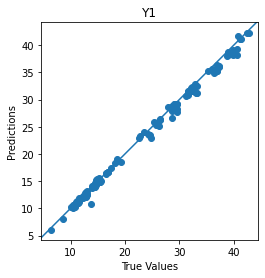

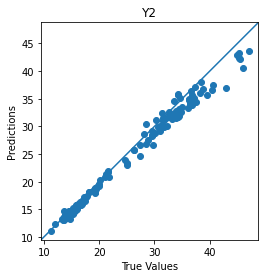

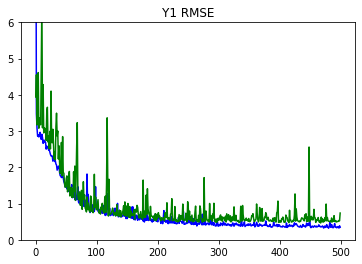

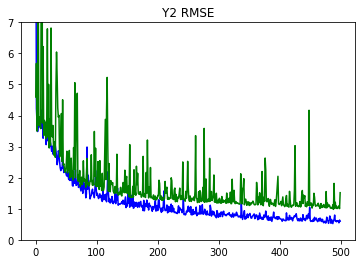

In [18]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)